In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


In [3]:
a = np.array([[1,2,3,1,1,1,1],[1,2],[1,2]])
print(type(a))
b = []
for x in a: b = b + x
print(b)

<class 'numpy.ndarray'>
[1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 2]


In [4]:
print(ratings.shape)
print(type(ratings))
print(type(ratings.data))
print(ratings.data.shape)
ratings_all = []
for x in ratings.data: ratings_all = ratings_all + x
print(set(ratings_all))

(1682, 943)
<class 'scipy.sparse.lil.lil_matrix'>
<class 'numpy.ndarray'>
(1682,)
{1.0, 2.0, 3.0, 4.0, 5.0}


### Plot the number of ratings per movie and user

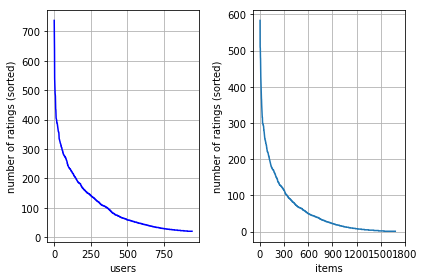

min # of items per user = 20, min # of users per item = 1.


In [5]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [6]:
print(num_items_per_user.shape)
print(num_users_per_item.shape)

(943,)
(1682,)


### Split the data into a train and test set

In [7]:
def split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # initiate train and test data
    test = sp.lil_matrix(valid_ratings.shape)
    train = sp.lil_matrix(valid_ratings.shape)
    
    for i in range(valid_ratings.shape[1]):
        
        # indices of non zero ratings
        ind_nz = valid_ratings[:,i].nonzero()[0]
        
        # shuffle the indices
        np.random.shuffle(ind_nz)
        
        # define a threshold for the split
        ind_thr = round(p_test*ind_nz.shape[0])

        # training set
        ind_train = ind_nz[ind_thr:]
        train[ind_train, i] = valid_ratings[ind_train,i]

        # test set
        ind_test = ind_nz[:ind_thr]
        test[ind_test, i] = valid_ratings[ind_test,i]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88162
Total number of nonzero elements in test data:9790


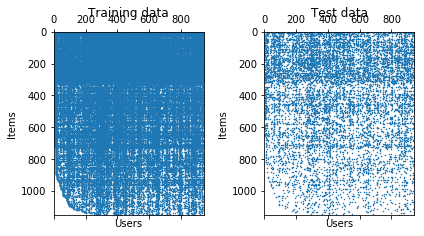

In [8]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

In [9]:
a = np.array([[0,1,0],[4,5,4]])
print(a.nonzero())
print(np.where(a==0))

(array([0, 1, 1, 1], dtype=int64), array([1, 0, 1, 2], dtype=int64))
(array([0, 0], dtype=int64), array([0, 2], dtype=int64))


## Implementing Baselines 

### Use the global mean to do the prediction

In [10]:
a = np.array([[1,2,3],[0,0,0],[0,1,0]])
print(a)
b = a
u = 0
b[np.where(b[:,u]==0)[0],u] = 1000
print(b)

print(np.where(a==0))
print(a.nonzero())
print(a[a.nonzero()].mean())
print(a.mean())

[[1 2 3]
 [0 0 0]
 [0 1 0]]
[[   1    2    3]
 [1000    0    0]
 [1000    1    0]]
(array([1, 1, 2], dtype=int64), array([1, 2, 2], dtype=int64))
(array([0, 0, 0, 1, 2, 2], dtype=int64), array([0, 1, 2, 0, 0, 1], dtype=int64))
334.5
223.0


In [11]:
from helpers import build_index_groups

a = np.array([[0,1,0],[4,5,4],[0,0,1]])
nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(a)
print(a)
print(nz_train)
print(nz_col_rowindices)

[[0 1 0]
 [4 5 4]
 [0 0 1]]
[(0, 1), (1, 0), (1, 1), (1, 2), (2, 2)]
[(0, array([1], dtype=int64)), (1, array([0, 1], dtype=int64)), (2, array([1, 2], dtype=int64))]


In [12]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""

    # train global mean
    global_mean_train = train[train.nonzero()].mean()  
    
    # mse
    loss_tr = calculate_mse(train[train.nonzero()].todense(), global_mean_train)
    loss_te = calculate_mse(test[test.nonzero()].todense(), global_mean_train)

    return loss_tr, loss_te

loss_tr, loss_te = baseline_global_mean(train, test)

print('Global mean prediction')
print('------------------------------------')
print('Training error : ', loss_tr)
print('Testing error : ', loss_te)

Global mean prediction
------------------------------------
Training error :  54947.4088893
Testing error :  6100.04069751


### Use the user means as the prediction

In [13]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    
    num_items, num_users = train.shape
    
    # copy the observed ratings 
    train_pred = train.copy()
    test_pred = test.copy()

    for u in range(num_users):
        
        # train user mean
        user_train = train[:,u]
        user_train_mean = user_train[user_train.nonzero()].mean() 
        
        # predict user test
        test_pred[:,u] = user_train_mean
        
        # predict user train
        train_pred[:,u] = user_train_mean

    # mse
    loss_tr = calculate_mse(train[train.nonzero()].todense(), train_pred[train.nonzero()].todense())
    loss_te = calculate_mse(test[test.nonzero()].todense(), test_pred[test.nonzero()].todense())

    return loss_tr, loss_te
    
loss_tr, loss_te = baseline_user_mean(train, test)

print('User mean prediction')
print('------------------------------------')
print('Training error : ', loss_tr)
print('Testing error : ', loss_te)

User mean prediction
------------------------------------
Training error :  46574.7761414
Testing error :  5312.7155885


### Use the item means as the prediction

In [14]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    
    num_items, num_users = train.shape
    
    # copy the observed ratings 
    train_pred = train.copy()
    test_pred = test.copy()

    for i in range(num_items):
        
        # train item mean
        item_train = train[i,:]
        item_train_mean = item_train[item_train.nonzero()].mean() 
        
        # predict item test
        test_pred[i,:] = item_train_mean
        
        # predict user train
        train_pred[i,:] = item_train_mean

    # mse
    loss_tr = calculate_mse( train[train.nonzero()].todense(), train_pred[train.nonzero()].todense() )
    loss_te = calculate_mse( test[test.nonzero()].todense(), test_pred[test.nonzero()].todense() )

    return loss_tr, loss_te
    
loss_tr, loss_te = baseline_item_mean(train, test)

print('Item mean prediction')
print('------------------------------------')
print('Training error : ', loss_tr)
print('Testing error : ', loss_te)

Item mean prediction
------------------------------------
Training error :  43947.9680905
Testing error :  5067.67136943


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [15]:
a = np.ones((5,1))
print(np.repeat(a,2,1))

[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]]


In [16]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""

    # user_features: shape = num_user, num_features
    # item_features: shape = num_item, num_features

    num_items, num_users = train.shape

    # item mean
    item_means = np.empty((num_items,1))
    for i in range(num_items):
        item_train = train[i,:]
        item_means[i,0] = item_train[item_train.nonzero()].mean()
    
    # user mean
    user_means = np.empty((num_users,1))
    for u in range(num_users):
        user_train = train[:,u]
        user_means[u,0] = user_train[user_train.nonzero()].mean()
        
    # user features    
    user_features = np.repeat(user_means/num_features, num_features, 1)
    
    # item features
    item_features = np.repeat(item_means/num_features, num_features, 1)
    
    return item_features, user_features 

Compute the cost by the method of matrix factorization.


In [27]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""

    # convert to array
    data = data.copy().toarray()

    # predicted ratings
    data_pred = item_features @ user_features.T

    # mse
    diff = np.array([data[ind] - data_pred[ind] for ind in nz])
    mse = 1/len(nz)*np.sum(diff.dot(diff.T))
    
    return np.sqrt(mse)

In [28]:
def compute_error_SOLUTION(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [29]:
max_rating = 5

# non zero 
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col))

# init using rating means
num_features = 4
W, Z = init_MF(train, num_features)

# random init 
W_rand = (max_rating/num_features)*np.random.rand(train.shape[0], num_features)
Z_rand = (max_rating/num_features)*np.random.rand(train.shape[1], num_features)

# compare init with mean and random init
e_mean = compute_error(train, Z, W, nz_train)
e_rand = compute_error(train, Z_rand, W_rand ,nz_train)

print('training error when init with item/user means: ', round(e_mean))
print('training error when init with random: ', round(e_rand))

training error when init with item/user means:  1.0
training error when init with random:  2.0


In [30]:
# compare init with mean and random init
e_mean = compute_error_SOLUTION(train, Z.T, W.T, nz_train)
e_rand = compute_error_SOLUTION(train, Z_rand.T, W_rand.T ,nz_train)

print('training error when init with item/user means: ', round(e_mean))
print('training error when init with random: ', round(e_rand))

training error when init with item/user means:  1.0
training error when init with random:  2.0


In [ ]:
print(Z.shape)
print(W.shape)

In [ ]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    
    # define parameters
    gamma = 0.01
    num_features = 10 # K in the lecture notes
    lambda_user = 0
    lambda_item = 0
    num_epochs = 20 # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(1)

    # init matrix
    W, Z = init_MF(train, num_features)
    
    # random init 
    #W = (max_rating/num_features)*np.random.rand(train.shape[0], num_features)
    #Z = (max_rating/num_features)*np.random.rand(train.shape[1], num_features)


    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")

    for it in range(num_epochs):

        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
   
            # prediction error
            e = train[d,n] - W[d,:]@Z[n,:].T 

            # stochastic gradients
            sg_w = -e*Z[n,:] + lambda_item*W[d,:] # regularized
            sg_z = -e*W[d,:] + lambda_user*Z[n,:] # regularized

            # udpate W and Z
            W[d,:] = W[d,:] - gamma*sg_w
            Z[n,:] = Z[n,:] - gamma*sg_z

        # rmse
        rmse = compute_error(train, Z, W, nz_train)
        errors.append(rmse)

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
    rmse = compute_error(test, Z, W, nz_test)
    
    plt.figure()
    plt.plot(errors[1:])
    plt.xlabel('iter')
    plt.ylabel('training error')
    plt.show()
    
    print("Lambda (user/item): {}/{}.".format(lambda_user, lambda_item))
    print("RMSE on train data: {}.".format(errors[-1]))
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 0.9872715644209179.
iter: 1, RMSE on training set: 0.9434630457128389.
iter: 2, RMSE on training set: 0.9307775671508333.
iter: 3, RMSE on training set: 0.9255709785848444.
iter: 4, RMSE on training set: 0.9227022873471015.
iter: 5, RMSE on training set: 0.9207816848601151.
iter: 6, RMSE on training set: 0.9197355238490305.
iter: 7, RMSE on training set: 0.9191632977804058.
iter: 8, RMSE on training set: 0.9185028097222825.
iter: 9, RMSE on training set: 0.9181706069463178.
iter: 10, RMSE on training set: 0.9179519846183768.
iter: 11, RMSE on training set: 0.917775521411073.
iter: 12, RMSE on training set: 0.9176596279686391.


### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(train, W, lambda_user):
    """update user feature matrix."""
    
    T = train>0.5
    T[T == True] = 1
    T[T == False] = 0

    Z = np.zeros((train.shape[0], W.shape[1]))

    for u, Tu in enumerate(T):
        Z[u] = np.linalg.solve(np.dot(W.T, np.dot(np.diag(Tu), W)) + lambda_user * np.eye(W.shape[1]), np.dot(W.T, np.dot(np.diag(Tu), train[u].T))).T
        
    return Z
    

def update_item_feature(train, Z, lambda_item):
    """update item feature matrix."""
    
    T = train>0.5
    T[T == True] = 1
    T[T == False] = 0

    W = np.zeros((train.shape[1], Z.shape[1]))

    for i, Ti in enumerate(T.T):
        W[:,i] = np.linalg.solve(np.dot(Z, np.dot(np.diag(Ti), Z.T)) + lambda_item * np.eye(Z.shape[1]), np.dot(Z, np.dot(np.diag(Ti), train[:, i])))
        
    return W
 

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # non zero in train
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        
        # update user feature & item feature
        user_features = update_user_feature(train, W, lambda_user)
        item_features = update_item_feature(train, Z, lambda_item)

        # error
        error = compute_error(train, user_features, item_features, nz_train)
        error_list.append(error)

        print("RMSE on training set: {}.".format(error))
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

ALS(train, test)

In [ ]:
a = np.array([1,2,3])
b = a
b[0] = 1000
print(a)
print(b)